In [2]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table
from astropy.coordinates import SkyCoord

from astropy import constants as const
from astropy import units as u

In [1]:
from astropy.table import Table

groups = Table.read(r"C:\Users\caeho\OneDrive\Documents\University of Rochester REU\SDSS_DR7_Mr20_groups.dat2",
                    format='ascii.commented_header')
groups

ID,RA,DEC,z,N,Mr_tot,g_r_tot,sigma_v,R_perp,rms,r_edge
int32,float64,float64,float64,int32,float64,float64,float64,float64,float64,float64
1,38.049133,0.224026,0.05402,1,-20.032,0.926,0.0,0.0,1.0,1.82
2,38.297181,0.04856,0.05406,3,-22.188,0.842,82.9,0.425,1.0,1.64
3,55.978967,0.526755,0.04028,2,-21.607,0.749,126.1,0.187,1.0,0.77
4,56.265446,0.618429,0.10564,1,-20.256,0.797,0.0,0.0,1.0,2.11
5,56.949131,0.57728,0.10006,1,-20.163,0.686,0.0,0.0,0.988,2.11
6,37.895509,1.003827,0.05442,1,-19.949,0.908,0.0,0.0,1.0,0.12
7,38.08029,0.594821,0.0212,2,-21.163,0.866,264.8,0.373,1.0,0.4
8,38.396365,0.962288,0.07265,1,-21.051,0.968,0.0,0.0,1.0,0.32
9,38.907034,1.031707,0.06714,1,-20.795,0.428,0.0,0.0,1.0,0.06


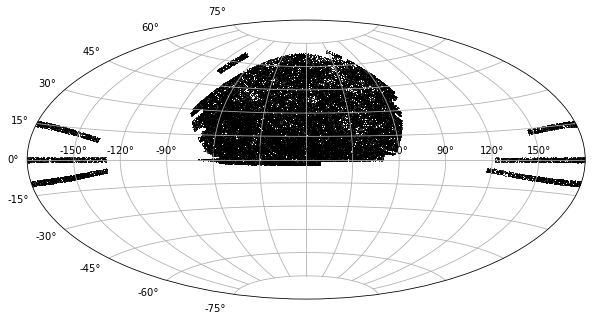

In [3]:
import astropy.units as u
import astropy.coordinates as coord
import astropy.units as u
from astropy.io import ascii
from astropy.coordinates import SkyCoord

plt.rcParams["figure.figsize"] = (10,6) #increase size of figure

#eq = SkyCoord(180-Mr20['RA'], Mr20['DEC'], unit=u.deg)
#gal = eq.galactic

gal = SkyCoord(ra=180-groups['RA'], dec=groups['DEC'], unit=u.deg)


plt.subplot(111, projection='aitoff')
plt.grid(True)
plt.scatter(gal.ra.wrap_at('180d').radian,
            gal.dec.radian, marker='o', c='k', s=1, lw=0); #added same marker appearance as above code

In [4]:
dwarf_table = Table.read('dwarf_table.txt', format = 'ascii.commented_header')
dwarf_table[:5]

aimc,IN_DR7_LSS,RA,DEC,Z,ELPETRO_ABSMAG_r,u_r,sSFR,HImass,flag3727,t3,Z12logOH,Zerr,logNO,NOerr,vflag_VF,ID,BPTclass,2D_neighbor_ID,2D_neighbor_dist,2D_neighbor_ID_vir,2D_neighbor_dist_vir,3D_neighbor_ID,3D_neighbor_dist,3D_neighbor_ID_vir,3D_neighbor_dist_vir
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int32,int32,float64,int32,float64,int32,float64,int32,float64,int32,float64
0.0,1.0,147.17645340393182,-0.3540349522432606,0.006282840855419636,-15.534673690795898,1.5979467332363129,-9.897252082824707,nan,nan,nan,nan,nan,nan,nan,2,12,1.0,49,0.18150554228021565,585714,1.3634632510011546,573,0.3210655024172438,208,2.3657856725525463
106.68,1.0,146.85676432411947,-0.27409664376066756,0.02196459472179413,-16.7003231048584,1.6220477223396301,-9.639364242553711,nan,nan,nan,nan,nan,nan,nan,2,31,1.0,79,0.6704515586457357,92,2.414294367856323,80,0.9556330809587631,585700,3.7385754919749274
0.0,1.0,146.19277353258968,-0.6882589506846374,0.004080323036760092,-15.290872573852539,1.220979243516922,-9.548693656921387,nan,nan,nan,nan,nan,nan,nan,2,44,1.0,585695,0.035663331434249095,639857,0.46035331496314846,585695,0.221530846641702,585695,2.8927174640703734
199.39,1.0,146.00780426178756,-0.6422574964819474,0.004776299931108952,-15.831652641296387,0.7728094607591629,-7.982375621795654,nan,0.0,1.5717060395681055,7.73051787768279,0.0179600111522654,-0.5320566539047968,0.44255404846002694,2,45,1.0,585695,0.006393284307917346,585695,0.08348257342324528,639857,0.6010801341408164,639857,7.109919536505821
0.0,1.0,146.6190367018052,-0.43434631860351913,0.006036635022610426,-16.34455108642578,1.7559601366519928,-9.769034385681152,nan,nan,nan,nan,nan,nan,nan,2,49,1.0,585714,0.07059729101415332,585714,0.4172620229334301,585714,0.3596492056527832,585714,2.125689993784549


In [ ]:
#creating the new columns
dwarf_table['Mr20_ID'] = -1
dwarf_table['Mr20_dist'] = np.nan

#columns for virial radius normalization 
dwarf_table['Mr20_ID_vir'] = -1
dwarf_table['Mr20_dist_vir'] = np.nan

h=1
H0 = 100*h*u.km/u.s/u.Mpc #Hubble's Constant




for i in range(len(dwarf_table)):
    
    #distances to systems
    dwarf_r = const.c.to('km/s')*dwarf_table['Z'][i]/H0 
    Mr20_r = const.c.to('km/s')*Mr20['z']/H0

    
    #galaxy positions to calcuate their separation
    dwarf_pos = SkyCoord(ra=dwarf_table['RA'][i]*u.degree, dec=dwarf_table['DEC'][i]*u.degree, distance=dwarf_r)
    Mr20_pos = SkyCoord(ra=Mr20['RA']*u.degree, 
                            dec=Mr20['DEC']*u.degree, distance=Mr20_r)
    neighbor_dist=Mr20_pos.separation_3d(dwarf_pos)
    
    nearby_neigh_index = np.argmin(neighbor_dist) #finding the nearest neighbor
    
    
    dwarf_table['Mr20_dist'][i] = neighbor_dist[nearby_neigh_index].value #unit Mpc
     
    neighbor_id = Mr20['ID']
    dwarf_table['Mr20_ID'][i] = neighbor_id[nearby_neigh_index] #ID# of the closest neighbor galaxy
    
    # Doing calculation with virial radius normalization
    
    
    
    r_vir = Mr20['R_perp,rms'] # calculating virial radius of all neighboring galaxies
    
    
    neighbor_dist_vir = neighbor_dist / r_vir # normalizing distance
    

    
    nearby_neigh_index_vir = np.nanargmin(neighbor_dist_vir) #finding closest neighbor with normalized virial distance
    
    dwarf_table['Mr20_dist_vir'][i] = neighbor_dist_vir[nearby_neigh_index_vir].value #unit , adding to dwarf table
    
    
    neighbor_id = Mr20['ID']
    dwarf_table['Mr20_ID_vir'][i] = neighbor_id[nearby_neigh_index_vir] #adding neighbor galaxy's ID to dwarf table